In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
df = pd.read_fwf('./wili dataset/x_train.txt', header=None)
X_train = df[[0]]
df = pd.read_fwf('./wili dataset/x_test.txt', header=None)
X_test = df[[0]]

In [3]:
target = pd.read_fwf('./wili dataset/y_train.txt',header = None)
y_train = target[[0]]
target = pd.read_fwf('./wili dataset/y_test.txt',header = None)
y_test = target[[0]]

In [4]:
y_train[y_train == 'be-tara'] = 'be-tarask'
y_train[y_train == 'roa-tar'] = 'roa-tara'

In [5]:
languages = ['eng', 'hin', 'mar', 'guj', 'tam', 'tcy', 'tel', 'pan', 'ben', 'mai']

In [6]:
train_index = y_train.index[y_train[0].isin(languages)].tolist()

In [7]:
test_index = y_test.index[y_test[0].isin(languages)].tolist()

In [8]:
X_train_p = X_train.iloc[train_index,:]
X_test_p = X_test.iloc[test_index,:]

In [9]:
y_train_p = y_train.iloc[train_index, :]
y_test_p = y_test.iloc[test_index, :]

### Tokenize Labels

In [10]:
label2int = {}
int2label = {}
counter = 0
for label in languages:
    if label not in label2int:
        label2int[label] = counter
        int2label[counter] = label
    counter += 1

In [11]:
pickle.dump(label2int, open('label2int.pkl', 'wb'))
pickle.dump(int2label, open('int2label.pkl', 'wb'))

### Tokenize target Variables

In [12]:
y_train_int = []
for label in y_train_p[0]:
    y_train_int.append(label2int[label])

In [13]:
y_test_int = []
for label in y_test_p[0]:
    y_test_int.append(label2int[label])

### Data Preprocessing

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
vectorizer = TfidfVectorizer(analyzer='char',min_df=25,lowercase=True, norm='l2')

In [16]:
vectorizer.fit(X_train_p[0])

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=25,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
X_train2int = vectorizer.transform(X_train_p[0]).toarray()

In [18]:
X_test2int = vectorizer.transform(X_test_p[0]).toarray()

In [19]:
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))

### Scaler

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
sc = StandardScaler()

In [22]:
sc.fit(X_train2int)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
X_train2int_sc = sc.transform(X_train2int)
X_test2int_sc = sc.transform(X_test2int)

In [24]:
pickle.dump(sc, open('scaler.pkl', 'wb'))

### PCA

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=80)

In [27]:
pca.fit(X_train2int_sc)

PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
X_train_pca = pca.transform(X_train2int_sc)

In [29]:
X_test_pca = pca.transform(X_test2int_sc)

In [30]:
import matplotlib.pyplot as plt

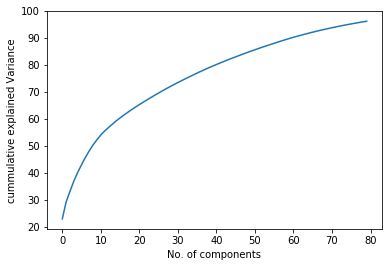

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

In [32]:
pickle.dump(pca, open('pca.pkl', 'wb'))

### One Hot Encoding

In [33]:
from sklearn.preprocessing import OneHotEncoder

In [34]:
y_train_int = np.array(y_train_int).reshape(-1, 1)
y_test_int = np.array(y_test_int).reshape(-1, 1)

In [35]:
enc = OneHotEncoder()

In [36]:
enc.fit(y_train_int)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [37]:
y_train_enc = enc.transform(y_train_int)
y_test_enc = enc.transform(y_test_int)

## Design ANN

In [38]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import model_from_json

C:\Users\Jatin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [39]:
clf = Sequential()
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu', input_dim = 80))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu'))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu'))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim =10  , kernel_initializer = 'uniform', activation='softmax'))

C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", input_dim=80, units=60)`
  
C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=60)`
  after removing the cwd from sys.path.
C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=60)`
  
C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="softmax", units=10)`
  


In [40]:
clf.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [41]:
with tf.device('/gpu:0'):
    history = clf.fit(X_train_pca, y_train_enc, batch_size=32, epochs=50, validation_data=(X_test_pca,y_test_enc))

Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [==============================] - 13s 3ms/step - loss: 1.2850 - acc: 0.6396 - val_loss: 0.2891 - val_acc: 0.9408
Epoch 2/50
5000/5000 [==============================] - 1s 167us/step - loss: 0.2251 - acc: 0.9402 - val_loss: 0.1580 - val_acc: 0.9608
Epoch 3/50
5000/5000 [==============================] - 1s 159us/step - loss: 0.1552 - acc: 0.9598 - val_loss: 0.1518 - val_acc: 0.9610
Epoch 4/50
5000/5000 [==============================] - 1s 182us/step - loss: 0.1364 - acc: 0.9638 - val_loss: 0.1515 - val_acc: 0.9620
Epoch 5/50
5000/5000 [==============================] - 1s 157us/step - loss: 0.1321 - acc: 0.9650 - val_loss: 0.1579 - val_acc: 0.9614
Epoch 6/50
5000/5000 [==============================] - 1s 153us/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1503 - val_acc: 0.9626
Epoch 7/50
5000/5000 [==============================] - 1s 154us/step - loss: 0.1100 - acc: 0.9732 - val_loss: 0.1623 - val_acc: 0.9630
E

In [42]:
model_json = clf.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
clf.save_weights("model.h5")

## Evaluation

In [43]:
y_pred_test_label = clf.predict(X_test_pca)
y_pred_train_label = clf.predict(X_train_pca)

In [44]:
y_pred_test = np.argmax(y_pred_test_label, axis=1)
y_pred_train = np.argmax(y_pred_train_label, axis=1)

In [45]:
y_train_true = y_train_int.astype(np.int)
y_test_true = y_test_int.astype(np.int)

## Graph Plot

### Model Accuracy Graph

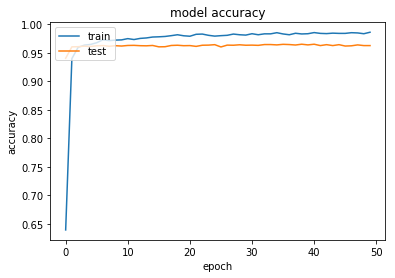

In [46]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Loss Graph

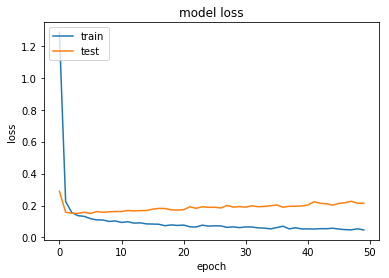

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Classification Report

In [48]:
from sklearn.metrics import classification_report

#### Train Data report

In [49]:
print(classification_report(y_train_true, y_pred_train))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       500
          1       0.99      0.99      0.99       500
          2       1.00      0.99      0.99       500
          3       1.00      0.99      0.99       500
          4       1.00      1.00      1.00       500
          5       1.00      1.00      1.00       500
          6       1.00      0.98      0.99       500
          7       1.00      1.00      1.00       500
          8       1.00      1.00      1.00       500
          9       1.00      0.98      0.99       500

avg / total       0.99      0.99      0.99      5000



#### Test Data Report

In [50]:
print(classification_report(y_test_true, y_pred_test))

             precision    recall  f1-score   support

          0       0.83      0.96      0.89       500
          1       0.97      0.94      0.95       500
          2       0.96      0.96      0.96       500
          3       0.99      0.97      0.98       500
          4       0.99      0.99      0.99       500
          5       1.00      1.00      1.00       500
          6       1.00      0.94      0.97       500
          7       0.99      0.98      0.99       500
          8       0.96      0.95      0.96       500
          9       0.97      0.93      0.95       500

avg / total       0.97      0.96      0.96      5000



## Confusion Matrix

In [51]:
from sklearn.metrics import confusion_matrix

### Train data

In [52]:
print(confusion_matrix(y_pred_train, y_train_true))

[[499   4   4   7   2   0  11   1   2   2]
 [  0 495   1   0   0   0   0   0   0   6]
 [  0   0 494   0   0   0   0   0   0   2]
 [  0   0   0 493   0   0   0   0   0   0]
 [  0   1   1   0 498   0   0   0   0   0]
 [  0   0   0   0   0 500   0   0   0   0]
 [  1   0   0   0   0   0 489   0   0   0]
 [  0   0   0   0   0   0   0 499   0   0]
 [  0   0   0   0   0   0   0   0 498   0]
 [  0   0   0   0   0   0   0   0   0 490]]


### Test data

In [53]:
print(confusion_matrix(y_pred_test, y_test_true))

[[481   8  12  15   2   0  24   7  20  12]
 [  0 471   2   0   0   0   0   0   0  15]
 [  1  12 482   0   0   0   1   0   1   5]
 [  3   0   1 483   0   0   1   0   1   0]
 [  0   1   0   0 494   0   0   0   1   2]
 [  0   0   0   0   0 500   0   1   0   0]
 [  2   0   0   0   0   0 471   0   0   0]
 [  2   0   0   1   0   0   1 491   0   0]
 [ 11   0   0   1   4   0   2   0 477   1]
 [  0   8   3   0   0   0   0   1   0 465]]


### Making Single Prediction

In [54]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [55]:
vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))
pca = pickle.load(open('pca.pkl', 'rb'))
label2int = pickle.load(open('label2int.pkl', 'rb'))
int2label = pickle.load(open('int2label.pkl', 'rb'))

In [56]:
input_single = "मेरा नाम जतिन है"
X_single = pd.DataFrame(data=[input_single], index=None)
X_single.to_csv('input.csv', encoding='utf-8', sep='\n', index=False,header=None)
X_single = pd.read_fwf('input.csv', delimiter = '\n', header = None, squeeze = True)
X_single

0    à¤®à¥‡à¤°à¤¾ à¤¨à¤¾à¤® à¤œà¤¤à¤¿à¤¨ à¤¹à¥ˆ
Name: 0, dtype: object

In [57]:
X_single = vectorizer.transform(X_single).toarray()
X_single = pca.transform(X_single)
y_pred_single = model.predict(X_single)

In [58]:
y_pred_single

array([[0.02470022, 0.34201685, 0.25560242, 0.00734947, 0.06024221,
        0.00180809, 0.00245256, 0.0036095 , 0.00436452, 0.2978542 ]],
      dtype=float32)

In [59]:
y_pred_single_val = np.argmax(y_pred_single, axis=1)

In [60]:
int2label[y_pred_single_val[0]]

'hin'